# ROC Curve Performance Analysis

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np
import pandas as pd
from joblib import load
from sklearn.metrics import roc_curve
plt.style.use([hep.style.ROOT, hep.style.firamath])

2022-03-28 15:39:12.171121: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-28 15:39:12.171311: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
version = '9.0.5'
train = pd.read_csv(f'../data_files/{version}/train.csv', index_col=[0])
X_train = train.drop(['category', 'Lb_M', 'IsSimulated'], axis=1)
y_train = train.category

val = df = pd.read_csv(f'../data_files/{version}/val.csv', index_col=[0])
X_val = val.drop(['category', 'Lb_M', 'IsSimulated'], axis=1)
y_val = val.category

test = df = pd.read_csv(f'../data_files/{version}/test.csv', index_col=[0])
X_test = test.drop(['category', 'Lb_M', 'IsSimulated'], axis=1)
y_test = test.category

In [10]:
nn = tf.keras.models.load_model(f'../neural_network/models/v{version}')
old_nn = tf.keras.models.load_model(f'../neural_network/models/v{version}')
knn = load(f'../classification_methods/models/KNN_{version}_tune.joblib')
rfc = load(f'../classification_methods/models/RFC_{version}_tune.joblib')
dtc = load(f'../classification_methods/models/DTC_{version}_tune.joblib')
xgb = load(f'../classification_methods/models/XGB_{version}.joblib')

models = {'NN': nn, 'KNN': knn, 'RFC': rfc, 'DTC': dtc, 'OLDNN': old_nn, 'XGB': xgb}

/root/envs/scientific/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/root/envs/scientific/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/root/envs/scientific/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 1.0.2. This might

In [6]:
# Define custom performance metric so that closer to 0 is better!
def roc_metric(T, F, k=10):
    # T = true positive rate
    # F = 1 - False positive rate
    metric = np.sqrt((1-T)**2+(1-F)**2) + k*np.abs(T-F)
    max_at = np.argmin(metric)
    return np.min(metric), T[max_at], F[max_at]

# Model Performance Across Sets

In [11]:
test_model = 'XGB'

In [12]:
roc_data = []
for dataset in [train, val, test]:
    roc = roc_curve(dataset['category'], models[test_model].predict_proba(dataset.drop(['category', 'Lb_M', 'IsSimulated'], axis=1))[:,1])
    roc_data.append([roc[1], 1-roc[0]])

/root/envs/scientific/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/root/envs/scientific/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/root/envs/scientific/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Train
True Positive Rate: 0.9627
False Positive Rate: 0.9628

Val
True Positive Rate: 0.9463
False Positive Rate: 0.9459

Test
True Positive Rate: 0.9497
False Positive Rate: 0.9498



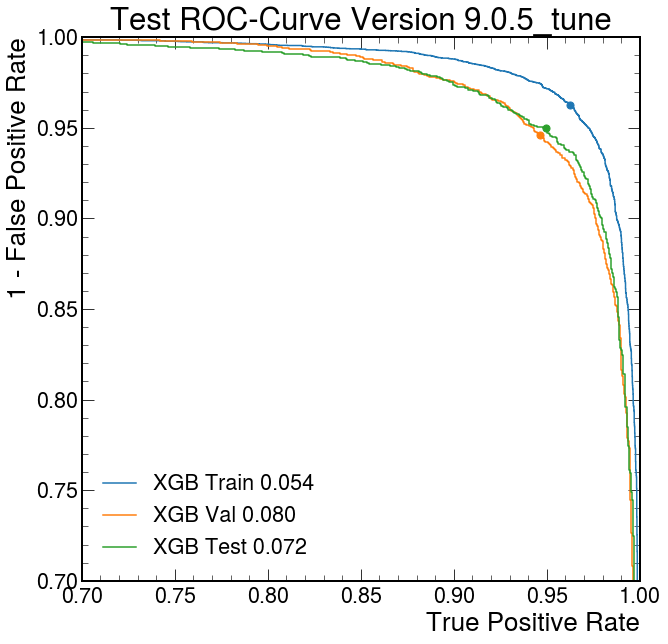

In [13]:
fig, ax = plt.subplots(1, 1)
datasets = ['train', 'val', 'test']
for i, j in enumerate(roc_data):
    best_metric = roc_metric(j[0], j[1])
    print(f'{datasets[i].capitalize()}\n============\nTrue Positive Rate: {best_metric[1]:.4f}\nFalse Positive Rate: {best_metric[2]:.4f}\n')
    ax.plot(j[0], j[1], label=f'{test_model} {datasets[i].capitalize()} {best_metric[0]:.3f}')
    ax.scatter(best_metric[1], best_metric[2], marker='o', s=50)
ax.set_xlim(0.7, 1)
ax.set_ylim(0.7, 1)
plt.ylabel('1 - False Positive Rate')
plt.xlabel('True Positive Rate')
plt.legend(loc='lower left')
plt.title(f'Test ROC-Curve Version {version}_tune')
plt.savefig(f'../images/ModelEval/{test_model}_ROC_{version}_Tune.png', dpi=800)
plt.show()

# Mega ROC Curve
Test data ROC across all models zoomed in. Best positions marked and $\zeta$ values given.

In [14]:
roc_data = []
for name, model in models.items():
    try:
        roc = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    except:
        roc = roc_curve(y_test, model.predict(X_test))
    roc_data.append([roc[1], 1-roc[0]])

2022-03-28 15:41:11.153205: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
/root/envs/scientific/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/root/envs/scientific/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/root/envs/scientific/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/root/envs/scientific/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


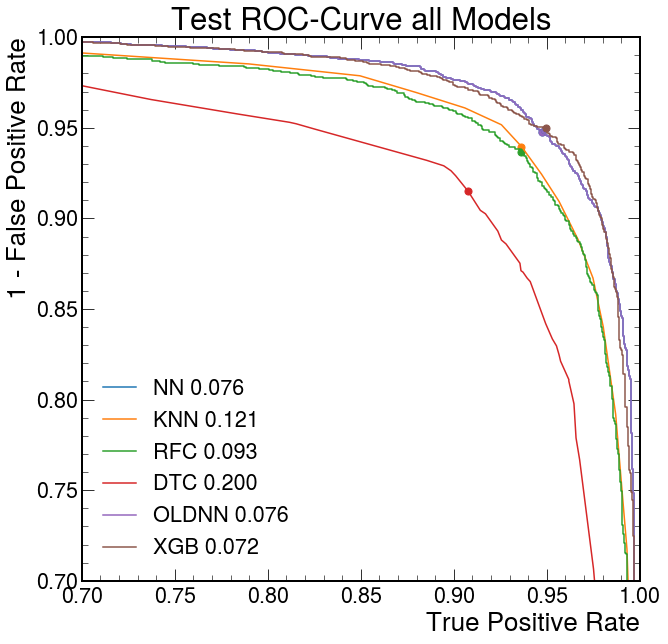

In [15]:
fig, ax = plt.subplots(1, 1)
for i, j in enumerate(roc_data):
    best_metric = roc_metric(j[0], j[1])
    ax.plot(j[0], j[1], label=f'{list(models.keys())[i]} {best_metric[0]:.3f}')
    ax.scatter(best_metric[1], best_metric[2], marker='o', s=50)
ax.set_xlim(0.7, 1)
ax.set_ylim(0.7, 1)
plt.ylabel('1 - False Positive Rate')
plt.xlabel('True Positive Rate')
plt.legend(loc='lower left')
plt.title(f'Test ROC-Curve all Models')
plt.savefig(f'../images/ModelEval/All_ROC_Test_Tune.png', dpi=800)
plt.show()